In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
class FactCheckDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Extract relevant fields
        row = self.data.iloc[index]
        statement = row["Statement"]
        evidence = row["Evidence_List"]  # Use multi-evidence as a single string
        label = row["labels"]

        # Optionally include context if available
        context = row["Context"] if "Context" in self.data.columns else None

        # Prepare the input text
        if context:
            input_text = f"Statement: {statement} Context: {context}"
        else:
            input_text = f"Statement: {statement}"

        # Tokenize statement, context, and evidence
        inputs = self.tokenizer(
            text=input_text,
            text_pair=evidence,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Return tokenized data and label
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [3]:
class FactCheckModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(FactCheckModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Use <cls> token
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)
        return logits

In [4]:
# Pre-trained model and tokenizer 
MODEL_NAME = "FPTAI/velectra-base-discriminator-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = FactCheckModel(model_name=MODEL_NAME, num_classes=3)

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/201k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

FactCheckModel(
  (bert): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32054, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [5]:
# Load train data
train = pd.read_csv('/kaggle/input/vifactcheck/train_data.csv')
train_dataset = FactCheckDataset(train, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load and preprocess dev data
dev = pd.read_csv('/kaggle/input/vifactcheck/dev_data.csv')
dev = dev.reset_index(drop=True)
expected_columns = ["Statement", "Evidence_List", "labels"]
missing_columns = [col for col in expected_columns if col not in dev.columns]
if missing_columns:
    raise ValueError(f"Missing columns in dev data: {missing_columns}")

dev_dataset = FactCheckDataset(dev, tokenizer, max_len=128)
dev_loader = DataLoader(dev_dataset, batch_size=16)

In [6]:
from tqdm import tqdm
from sklearn.metrics import classification_report

def train_model(model, train_loader, dev_loader, optimizer, loss_fn, epochs=5, save_path="best_model.pth"):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = loss_fn(logits, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}")


        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validating"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
        
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()
        
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_acc = correct / total
        print(f"Validation Loss: {val_loss / len(dev_loader):.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Print detailed metrics
        print(classification_report(all_labels, all_preds, target_names=["supported", "refuted", "n.e.i"]))

In [7]:
train_model(model, train_loader, dev_loader, optimizer, loss_fn, epochs=5)

Training Epoch 1: 100%|██████████| 317/317 [01:01<00:00,  5.18it/s]


Epoch 1, Train Loss: 1.0739


Validating: 100%|██████████| 46/46 [00:05<00:00,  8.18it/s]


Validation Loss: 0.9218, Validation Accuracy: 0.5671
              precision    recall  f1-score   support

   supported       0.53      0.75      0.62       256
     refuted       0.52      0.56      0.54       244
       n.e.i       0.85      0.37      0.51       223

    accuracy                           0.57       723
   macro avg       0.63      0.56      0.56       723
weighted avg       0.62      0.57      0.56       723



Training Epoch 2: 100%|██████████| 317/317 [01:00<00:00,  5.23it/s]


Epoch 2, Train Loss: 0.7609


Validating: 100%|██████████| 46/46 [00:05<00:00,  7.96it/s]


Validation Loss: 0.6869, Validation Accuracy: 0.7123
              precision    recall  f1-score   support

   supported       0.72      0.71      0.72       256
     refuted       0.70      0.64      0.67       244
       n.e.i       0.71      0.80      0.75       223

    accuracy                           0.71       723
   macro avg       0.71      0.71      0.71       723
weighted avg       0.71      0.71      0.71       723



Training Epoch 3: 100%|██████████| 317/317 [01:00<00:00,  5.23it/s]


Epoch 3, Train Loss: 0.5867


Validating: 100%|██████████| 46/46 [00:05<00:00,  8.01it/s]


Validation Loss: 0.8174, Validation Accuracy: 0.6708
              precision    recall  f1-score   support

   supported       0.85      0.48      0.62       256
     refuted       0.56      0.83      0.67       244
       n.e.i       0.75      0.71      0.73       223

    accuracy                           0.67       723
   macro avg       0.72      0.67      0.67       723
weighted avg       0.72      0.67      0.67       723



Training Epoch 4: 100%|██████████| 317/317 [01:00<00:00,  5.22it/s]


Epoch 4, Train Loss: 0.4371


Validating: 100%|██████████| 46/46 [00:05<00:00,  8.04it/s]


Validation Loss: 0.8016, Validation Accuracy: 0.6985
              precision    recall  f1-score   support

   supported       0.74      0.65      0.69       256
     refuted       0.62      0.79      0.69       244
       n.e.i       0.79      0.66      0.72       223

    accuracy                           0.70       723
   macro avg       0.71      0.70      0.70       723
weighted avg       0.71      0.70      0.70       723



Training Epoch 5: 100%|██████████| 317/317 [01:00<00:00,  5.22it/s]


Epoch 5, Train Loss: 0.3036


Validating: 100%|██████████| 46/46 [00:05<00:00,  8.04it/s]

Validation Loss: 1.0758, Validation Accuracy: 0.7026
              precision    recall  f1-score   support

   supported       0.81      0.61      0.69       256
     refuted       0.61      0.81      0.69       244
       n.e.i       0.76      0.69      0.72       223

    accuracy                           0.70       723
   macro avg       0.72      0.70      0.70       723
weighted avg       0.72      0.70      0.70       723



In [8]:
def predict(model, tokenizer, statement, evidence, max_len=128):
    model.eval()
    inputs = tokenizer(
        text=statement,
        text_pair=evidence,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()

    return prediction, probs

In [9]:
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # To store probabilities for ROC-AUC and PR-AUC calculations

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Model predictions
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(logits, dim=1)  # Probabilities for ROC-AUC and PR-AUC
            preds = torch.argmax(logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Label 0', 'Label 1', 'Label 2'], yticklabels=['Label 0', 'Label 1', 'Label 2'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, and F1-Score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")

    # ROC-AUC (for multi-class)
    try:
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        print(f"ROC-AUC: {roc_auc:.4f}")
    except ValueError:
        print("ROC-AUC could not be calculated due to incompatible inputs.")

    # PR-AUC (for multi-class, using average_precision_score)
    try:
        pr_auc = average_precision_score(all_labels, all_probs, average='macro')
        print(f"PR-AUC: {pr_auc:.4f}")
    except ValueError:
        print("PR-AUC could not be calculated due to incompatible inputs.")

    return all_preds, all_labels


In [10]:
# Load and preprocess dev data
test = pd.read_csv('/kaggle/input/vifactcheck/test_data.csv')
test = test.reset_index(drop=True)
expected_columns = ["Statement", "Evidence_List", "labels"]
missing_columns = [col for col in expected_columns if col not in test.columns]
if missing_columns:
    raise ValueError(f"Missing columns in test data: {missing_columns}")

test_dataset = FactCheckDataset(test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=16)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       508
           1       0.60      0.79      0.68       468
           2       0.78      0.74      0.76       471

    accuracy                           0.71      1447
   macro avg       0.73      0.72      0.71      1447
weighted avg       0.73      0.71      0.71      1447



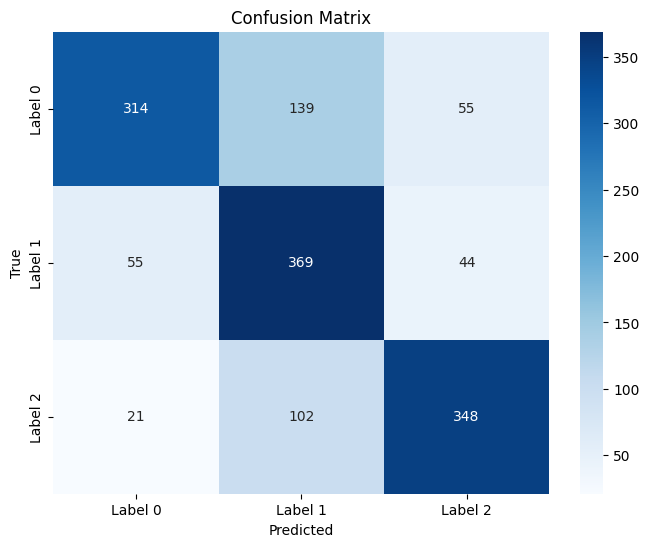

Accuracy: 0.7125
Precision: 0.7317
Recall: 0.7125
F1-Score (Macro): 0.7140
F1-Score (Micro): 0.7125
ROC-AUC: 0.8886
PR-AUC could not be calculated due to incompatible inputs.


In [11]:
# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_loader)

In [12]:
def visualize_predictions(data, predictions, labels, n=5):
    for i in range(n):
        print(f"Statement: {data.iloc[i]['Statement']}")
        print(f"Evidence: {data.iloc[i]['Evidence']}")
        print(f"True Label: {labels[i]}, Predicted Label: {predictions[i]}")
        print("-" * 50)

visualize_predictions(test, test_preds, test_labels)

Statement: Bộ xương bản sao được đưa đến Lodon bằng cách nghép thành con hoàn chỉnh rồi vận chuyển đến.
Evidence: đại diện Bảo tàng Lịch sử tự nhiên London cho biết bộ xương bản sao đã được đưa đến London trong 32 thùng riêng biệt, nghĩa là "mỗi mảnh phải được ghép lại với nhau như một trò chơi ghép hình khổng lồ".
True Label: 1, Predicted Label: 2
--------------------------------------------------
Statement: Phần vỏ bánh được làm rất công phu, từ giai đoạn xay gạo đến cuốn bánh hết tổng 4 tiếng đồng hồ.
Evidence: Gạo tẻ ngon được xay nhuyễn bằng cối đá từ xưa, sau đó loại bỏ tạp chất bằng cách lọc qua nước để lấy bột nõn. Đây là công thức từ thời mẹ ông để lại và vẫn được ông duy trì những năm qua. Khách đến gọi mới được phục vụ. Bột tráng bánh được múc theo từng muôi rưới lên mặt nồi hấp, tráng đều rồi đậy vung. Hấp khoảng một phút vỏ bánh vừa chín tới, có độ dai nhẹ. Ông Chính dùng que tre dẹt cuốn lấy vỏ bánh đặt lên đĩa, cho phần nhân đã được xào chín vào rồi cẩn thận cuộn tròn sa